In [365]:
## Process AlpArray Switzerland for SKS-Splitting
## Gerrit Hein
######################################################
######### LOAD IN THE MODULES
######################################################
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import matplotlib.pyplot as plt
import numpy as np

import os
import obspy
from obspy import read
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.taup import TauPyModel
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import locations2degrees
from obspy.taup import plot_travel_times
from obspy.geodetics import locations2degrees
from obspy.signal.rotate import rotate_ne_rt
from obspy.signal.polarization import particle_motion_odr

from obspy.signal.util import next_pow_2

import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit

from matplotlib.mlab import specgram

from tqdm import tqdm
import time

import multiprocessing

import splitwavepy as sw
import multiprocessing
import seaborn as sns
import scipy
import pandas as pd
######################################################
######################################################
from scipy import stats


# TASKS:

1. do the simple time window test for Chevrot
--> look at clustering of Splitting intensities
--> find max in distribution and take as "best SI" and then fit function

--> before: we fitted Sinusoid for all different time windows and choose the fit with minimum Variance

- Seaborn or Hist2D plot of found Dt vs phi with the fitted values for 1 station
-> extend and compare 
--> compare min Variance versus max in Distribution
***
2. run the k-means cluster Test for the found Phi and dt
--> split into 2 clusters ? pick the one with least error
--> take the best from 1 or the other cluster and compare with the rest

3. verify the found clusters with Chi-Square Test and accept if positive

***
# Afterwards

- implenent Wiener Filter from Montelleir
- Bayesian Inversion for 2 Layer Splitting, see for that: code_latest/SplitWave/splitwavepy-master/devel/Bayesian_Inversion.ipynb)
***
- next step: extend to AlpArray Austria
***

In [3]:
###############################################################
######### CHECK STATIONS AND EVENT CATALOGUE
###############################################################
client = Client("ETH") # ORFEUS
station= '*'
starttime = UTCDateTime("2000-01-01T00:00:00.000")
endtime = UTCDateTime("2018-12-31T00:00:00.000")

inventory = client.get_stations(network="CH", station=station, starttime=starttime, endtime=endtime)
stationlist = inventory[0]

In [5]:
###############################################################
######### EVENT CATALOGUE
###############################################################
cat = obspy.read_events("/home/hein/Dropbox/PhD/code_PhD/qcmt.ndk")
#cat = cat.filter("time > {0}".format(station.start_date),"time < 2018-12-01T00:00:00")
cat = cat.filter("time > 2000-01-01T00:00","time < 2018-12-01T00:00:00")
cat_m7 = cat.filter("magnitude >= 7.0")
cat_m7.write("/home/hein/Dropbox/PhD/code_PhD/qcmt_edit.cmt",format="CMTSOLUTION")
#cat_m7.plot() 
counter = 0
long_list = []

for ev in cat_m7:    
    event1 = ev
    ### Event parameters
    orig  = event1.origins

    mag = event1.magnitudes[0]
    
    for station in stationlist:        
        ### check if station has recorded before event 
        if (float(station.start_date)<float(orig[0].time)) and (station.end_date == None):


            dist_deg = locations2degrees(orig[0].latitude, orig[0].longitude,
                           station.latitude, station.longitude)
            ## check wheter distance is in the right range            
            if (dist_deg>95) and (dist_deg<145):
                counter +=1

                tmp = [counter, str(station.code), station.start_date, station.latitude,
                                              station.longitude, orig[0].time,
                                    orig[0].latitude, orig[0].longitude, orig[0].depth, mag.mag, dist_deg]
                long_list.append(tmp)


In [6]:
#################################################################################
######### READ STATION SKRIPT
#################################################################################
def read_station_event_data(istation):
    #### to get all waveforms of 1 station
    st_lat_list = []
    st_lon_list = []        
    ev_lat_list =[]
    ev_lon_list =[]
    ev_time_list = []
    ev_depth_list = []    
    ev_mag_list = []
    ev_dist_list = []
    back_azimut_list =[]    
    t_SKS_list = []
    t_SKKS_list = []
    t_SKS=0     
    t_SKKS=0 
    t_PP=0     
    t_PP_list = []    

    PHASE_LIST = ['PP','SKS','SKKS']
    st_event = obspy.Stream()
    for iSKS in long_list:    
#    for iSKS in long_list[0:25]:
        
        if iSKS[1]==istation:
#            print(iSKS[1])
            filename='{0}/{1}/{2}.{3}.{4}.{5}.{6}.{7}.CH.{8}.BH?..SAC'.format(save_loc,iSKS[1],iSKS[5].year,
                                                              iSKS[5].julday,iSKS[5].hour,
                                                              iSKS[5].minute,iSKS[5].second,
                                                              iSKS[5].microsecond/100,
                                                              iSKS[1])

        ## something which only gets the data for 1 events
#            print(filename)
            st_tmp=obspy.Stream()
            try:
            
        #                print('reading', iSKS[1])
                st_tmp += read(filename)

                if len(st_tmp)>2:

                    if (st_tmp[0].stats.npts > 36000 and st_tmp[1].stats.npts > 36000 and st_tmp[2].stats.npts > 36000):


                        st_lat = iSKS[3]
                        st_lon = iSKS[4]
                        ev_time = UTCDateTime(iSKS[5])     
                        ev_lat = iSKS[6]
                        ev_lon = iSKS[7]
                        ev_depth = iSKS[8]
                        ev_mag = iSKS[9]  
                        ev_dist = iSKS[10]

                        st_lat_list.append(st_lat)
                        st_lon_list.append(st_lon)                    
                        ev_lat_list.append(ev_lat)
                        ev_lon_list.append(ev_lon)        
                        ev_time_list.append(ev_time)
                        ev_depth_list.append(ev_depth)
                        ev_mag_list.append(ev_mag)
                        ev_dist_list.append(ev_dist)

                        dist_deg = locations2degrees(ev_lat,ev_lon,
                                   st_lat,st_lon)

                        arrivals = model.get_travel_times(source_depth_in_km=ev_depth/1000, distance_in_degree=dist_deg,phase_list=PHASE_LIST)

                        geodetics = gps2dist_azimuth(ev_lat, ev_lon,
                               st_lat, st_lon, a=6378137.0, f=0.0033528106647474805)

                        back_azimut = geodetics[2]
                        back_azimut_list.append(back_azimut)

                        for i in range(0,len(arrivals)):
                            if arrivals[i].name=='SKS':
                                t_SKS = arrivals[i].time
                            elif (arrivals[i].name=='SKKS' and t_SKKS==0):
                                t_SKKS = arrivals[i].time     
                            elif arrivals[i].name=='PP':
                                t_PP = arrivals[i].time

                        t_SKS_list.append(t_SKS)
                        t_SKKS_list.append(t_SKKS)                        
                        t_PP_list.append(t_PP)                                                

                        st_event +=st_tmp
                    else:
                        print('Stream has too few samples')
                else:
                    print('Stream has not 3 channels')



            except:
                print('no matching file')
            

    return st_event,st_lat_list,st_lon_list,ev_lat_list,ev_lon_list,ev_time_list,ev_depth_list,ev_mag_list,ev_dist_list,back_azimut_list, t_SKS_list,t_SKKS_list,t_PP_list


In [7]:
#################################################################################
######### SPLITWAVE ROUTINES 
#################################################################################

    

def Splitwave_Eig3D(st_cut,plot=False):

    tmp = st_cut
    delta = tmp[0].stats.delta
#    print(delta)
    t = sw.Trio(tmp[1].data,tmp[0].data, tmp[2].data,delta=delta)
    #t = sw.Pair(st_slice[1].data,)

    ## write something for time window
    t1 = 10
    t2 = 70
    t.set_window(t1,t2)
#    t.plot()

    b = sw.Eig3dM(t,lags=(2.5,))
    
    try:  
        path_Methods='{0}/../SplitWave_Results/Methods/Eig3D/{1}/'.format(save_loc,st_cut[0].stats.station)
#        os.mkdir(path_Methods)
    except:
        pass
#    b.save('/media/hein/home2/SplitWave_Results/Splitws/Window_Tests/{0}_{1}.eig'.format(st_cut[0].stats.station,st_cut[0].stats.starttime.strftime("%Y-%m-%d")))    
    if plot==True:
        fig = b.plot()
        fig.savefig('/media/hein/home2/SplitWave_Results/Splitws/Window_Tests{0}/{0}_{1}.eig'.format(st_cut[0].stats.station, st_cut[0].stats.starttime.strftime("%Y-%m-%d")))
    

    return b.fast, b.dfast,round(b.lag,4),round(b.dlag,4)


def Splitwave_EigM(st_cut,t1,t2,plot=False):
    # get data into Pair object and plot
    tmp = st_cut    
    north = tmp[1].data
    east = tmp[0].data
    sample_interval = tmp[0].stats.delta
    try:  
        realdata = sw.Pair(north, east, delta=sample_interval)
        ## write something for time window    
        t1 = t1
        t2 = t2
        realdata.set_window(t1,t2)
       # realdata.plot()

        measure = sw.EigenM(realdata,lags=(2.5,))
    except:
        print('Time Window Too Short, set vals to nan')        
        measure = sw.CrossM(delta=0.1)
        measure.fast = np.nan
        measure.dfast = np.nan
        measure.lag = np.nan
        measure.dlag = np.nan
        pass
    
#    measure.save('/media/hein/home2/SplitWave_Results/Methods/EigM/{0}_{1}.eig'.format(st_cut[0].stats.station,st_cut[0].stats.starttime.strftime("%Y-%m-%d")))    
    if plot==True:
#         fig,ax = plt.figure(figsize=(16,9))
        measure.plot()
#         fig.savefig('/media/hein/home2/SplitWave_Results/Splitws/Window_Tests{0}/EigM_{0}_{1}.eig'.format(st_cut[0].stats.station, st_cut[0].stats.starttime.strftime("%Y-%m-%d")))    
    
    return measure.fast, measure.dfast,round(measure.lag,4),round(measure.dlag,4)


def Splitwave_TransM(st_cut,t1,t2,back_az,plot=False):
    tmp = st_cut    
    north = tmp[1].data
    east = tmp[0].data
    sample_interval = tmp[0].stats.delta
    ## write something for time window    
    try:      
        realdata = sw.Pair(north, east, delta=sample_interval)        
        t1 = t1
        t2 = t2
        realdata.set_window(t1,t2)
        #realdata.plot()

        m = sw.TransM(realdata, pol=back_az, lags=(2.5,))
    except:
        print('Time Window Too Short, set vals to nan')
        m = sw.CrossM(delta=0.1)
        m.fast = np.nan
        m.dfast = np.nan
        m.lag = np.nan
        m.dlag = np.nan
        pass

    
    if plot==True:
#         fig,ax = plt.figure(figsize=(16,9))
        m.plot()

#         fig.savefig('/media/hein/home2/SplitWave_Results/Splitws/Window_Tests{0}/TransM_{0}_{1}.eig'.format(st_cut[0].stats.station, st_cut[0].stats.starttime.strftime("%Y-%m-%d")))

    return m.fast, m.dfast,round(m.lag,4),round(m.dlag,4)


def Splitwave_CrossC(st_cut,t1,t2,plot=False):
    tmp = st_cut    
    north = tmp[1].data
    east = tmp[0].data
    sample_interval = tmp[0].stats.delta
#     realdata = sw.Pair(north, east, delta=sample_interval)
#     ## write something for time window    
#     t1 = t1
#     t2 = t2
    try:  
        realdata = sw.Pair(north, east, delta=sample_interval)
        ## write something for time window    
        t1 = t1
        t2 = t2

        realdata.set_window(t1,t2)
      #  realdata.plot()

        m = sw.CrossM(realdata, lags=(2.5,))
    except:
        print('Time Window Too Short, set vals to nan')
        m = sw.CrossM(delta=0.1)
        m.fast = np.nan
        m.dfast = np.nan
        m.lag = np.nan
        m.dlag = np.nan
        pass
#     realdata.set_window(t1,t2)
#   #  realdata.plot()

#     m = sw.CrossM(realdata, lags=(2.5,))
    
#    m.save('/media/hein/home2/SplitWave_Results/Splitws/Window_Tests{0}/{0}_{1}.eig'.format(st_cut[0].stats.station, st_cut[0].stats.starttime.strftime("%Y-%m-%d")))
    if plot==True:
#         fig,ax = plt.figure(figsize=(16,9))
        m.plot()
#         fig.savefig('/media/hein/home2/SplitWave_Results/Splitws/Window_Tests{0}/CrossC_{0}_{1}.eig'.format(st_cut[0].stats.station, st_cut[0].stats.starttime.strftime("%Y-%m-%d")))

    
    return m.fast, m.dfast,round(m.lag,4),round(m.dlag,4)

def calc_sft(st,t1,t2):    
    st_slice = st.slice(starttime=t1,endtime=t2)
    max_percentage=0.05
#    st_slice = st_slice.filter("bandpass",freqmin=0.1,freqmax=0.5)
    
    st_slice = st_slice.taper(max_percentage, type='hann', max_length=None, side='both')

    ## to be entirely sure, take the maximum energy on E and N component
    st_amplitude = np.sqrt(st_slice[0].data**2+st_slice[1].data**2)
    winlen=10
    power = 2**7 #NFFT=winlen*st_slice[0].stats.sampling_rate
    s, f, t = specgram(st_slice[0].data,NFFT=power, noverlap=int(power*0.5),pad_to=int(power*2),Fs=10)    
    slog = 10 * np.log10(s)
    #print(st_slice)
    return s,f,t,slog,st_slice



In [8]:
#################################################################################
######### CHEVROT METHOD 
#################################################################################
## take time window of N and E wave
## get particle direction for max pulse
## rotate to RT
## calc Splitting Vector 
## generalize for EVENTS
## now calc for several events
## make azimuth vs SV amplitude plot
## fit a Least Square sinusoid
def get_real_SKS_arrival(st_work):

    
    ampl = np.sqrt(st_work[0].data**2+st_work[1].data**2)
    max_ampl = np.max(ampl)
    max_idx = np.argmax(ampl)    
    tvec = np.linspace(float(st_work[0].stats.starttime),float(st_work[0].stats.endtime),st_work[0].stats.npts)
    t_SKS_real = tvec[max_idx]
    t_SKS_real = UTCDateTime(t_SKS_real)
    
    return t_SKS_real


def get_latest_start(st_cut):

    latest_start = [float(st_cut[0].stats.starttime),float(st_cut[1].stats.starttime),float(st_cut[2].stats.starttime)]
    
    least_samps = [float(st_cut[0].stats.npts),float(st_cut[1].stats.npts),float(st_cut[2].stats.npts)]
            
    ## make new trace with the minimum
    st_cut[0].data = st_cut[0].data[:int(min(least_samps))]
    st_cut[1].data =st_cut[1].data[:int(min(least_samps))]
    st_cut[2].data = st_cut[2].data[:int(min(least_samps))]
#    st_cut = st_cut.slice(UTCDateTime(np.max(latest_start)),UTCDateTime(np.max(latest_start))+np.min(least_samps)-10,nearest_sample=True)
#    print(st_cut)
    
    return st_cut



def splittingintensity(rdiff,trans):
    """
    Calculate splitting intensity.
    """
    s = -2 * np.trapz(trans * rdiff) / np.trapz(rdiff**2)
    return s




def SKS_Intensity_Chevrot(st_c,ev_time,t_SKS,back_azimut,twin,plot=False):
    
    plt.rcParams.update({'font.size': 12})
    st_c = st_c.sort()
#    for ev_step in range(0,len(ev_time_l)):    
    ### SORT IT AS ZNE

    st_stream = obspy.Stream()
    tmp = st_c[2]
    st_stream +=tmp
    tmp = st_c[1]
    st_stream +=tmp
    tmp = st_c[0]
    st_stream +=tmp

    gridspec.GridSpec(2,3)
    arrival_time = ev_time+t_SKS

    ### USE CORRECT ARRIVAL TIME
    ### Take small time window around arrival time 
    twin = twin

    st_stream = st_stream.slice(arrival_time-twin,arrival_time+twin,nearest_sample=True)

    st_stream = get_latest_start(st_stream) ## FOR ISSUE WITH UNEVEN SAMPLES 

    
    limits=np.max([abs(st_stream[2].data),abs(st_stream[2].data)])*2*10**6

    #### CALC THE POLARIZATION OF PARTICLE MOTION
    ## only accept the upper half for Signal
    noise_level=st_stream[0].data**2+st_stream[1].data**2+st_stream[2].data**2
    azimuth, incidence, az_error, in_error = particle_motion_odr(st_stream, noise_thres=np.mean([np.max(noise_level), np.min(noise_level)])+np.std([np.max(noise_level), np.min(noise_level)]))
#    print(az_error)
    ### ROTATE THE SYSTEM FROM NE TO RT
    st_rot_RT = rotate_ne_rt(st_stream[1].data,st_stream[2].data,180+azimuth)    
    
    radial = st_rot_RT[0]
    r_dot = np.diff(radial)/st_stream[1].stats.delta
        
    radial = radial[0:len(r_dot)]
    transverse=st_rot_RT[1][0:len(r_dot)]    

    r_2 = np.sum(r_dot**2)
    ### NORMALIZE SPLITTING VECTOR
    SV_EQ = -np.sum(2*r_dot*transverse)/r_2
    ## same with walpoles implementation, so clean up?
#    s = splittingintensity(r_dot,transverse)
#    print('Walpole ',s)
#    print('me',SV_EQ)


    sigma = np.sqrt(np.sum((transverse+0.5*r_dot*SV_EQ)**2))
#    print(sigma)
    
    ### EVENT AZIMUT IS BACK-AZIMUT +180
    if back_azimut+180>360:
        Az = back_azimut-180
    else:
        Az=back_azimut+180
    SV_Az = SV_EQ 

    if plot==True:
    ### Only Plotting Below     
        fig = plt.figure(figsize=(16,9))
#        plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=1)        
        ax1 = fig.add_axes([0.1,0.5,0.5,0.3])    
        ax2 = fig.add_axes([0.65,0.5,0.25,0.3])        
        ax3 = fig.add_axes([0.1,0.1,0.5,0.3])     
        ax4 = fig.add_axes([0.65,0.1,0.25,0.3])            
        
        timevec = np.linspace(float(st_stream[0].stats.starttime),float(st_stream[0].stats.endtime),st_stream[0].stats.npts)

        xxticks = np.linspace(timevec[0], timevec[-1],10)
        xxlabels=[]
        for i in range(0,len(xxticks)):
            tmp=UTCDateTime(xxticks[i]).strftime('%H:%M:%S')
            xxlabels.append(tmp)
            
    ########### SET PROPER TIME AXIS    


        ax1.plot(timevec,st_stream[1].data*10**6,'g',label='North')
        ax1.plot(timevec,st_stream[2].data*10**6,'b',label='East')
        ax1.vlines(x=float(arrival_time),ymin=1.3*np.min(np.min([st_stream[1].data*10**6,st_stream[2].data*10**6])),ymax=1.3*np.max(np.max([st_stream[1].data*10**6,st_stream[2].data*10**6])),color='k',linewidth=0.5,label='SKS-Phase')
        ax1.set_title('{0}, SKS-arrival at: {1}, Backazimut={2} $^\circ$, SI={3}'.format(st_stream[0].stats.station,arrival_time.strftime('%Y-%m-%d, %H:%M:%S'),round(Az,2),round(SV_Az,2)))
        ax1.set_xlabel('Time [s]')
        ax1.set_ylabel('displacement [$\mu$m]')  
        ax1.set_xlim(timevec[0],timevec[-1])            
        ax1.set_xticks(xxticks)
        ax1.set_xticklabels(xxlabels)            
        ax1.grid()        
        ax1.legend()

#        plt.subplot2grid((2,3), (0,2))
        ax2.plot(st_stream[2].data*10**6,st_stream[1].data/10**-6,color='black',linestyle='dashed')
        ax2.set_xlabel('East disp. [$\mu$m]')
        ax2.set_ylabel('North disp. [$\mu$m]')
        ax2.axis('equal')
        ax2.set_xlim(-limits, limits)
        ax2.set_ylim(-limits, limits)
        ax2.grid()
        ax2.set_title('Polarization: Azimuth={0}$^\circ$'.format(round(azimuth,2)))
        
#        limits = 1        
#        limits = np.max([np.max(radial),np.max(transverse)])
    
# #        plt.subplot2grid((2,3), (1,0), colspan=2, rowspan=1)
        ax3.plot(timevec[0:-1],radial*10**6,'r',label='Radial')
        ax3.plot(timevec[0:-1],transverse*10**6,'b',label='Transverse') 
        ax3.plot(timevec[0:-1],-0.5*r_dot*(np.max(transverse)/np.max(r_dot))*10**6,color='g',label='radial-derivate',alpha=0.5,linewidth=0.5)
        ax3.vlines(x=float(arrival_time),ymin=1.3*np.min(np.min([st_stream[1].data*10**6,st_stream[2].data*10**6])),ymax=1.3*np.max(np.max([st_stream[1].data*10**6,st_stream[2].data*10**6])),color='k',linewidth=0.5,label='SKS-Phase')        
        ax3.set_xlabel('Time [s]')
        ax3.set_ylabel('displacement [$\mu$m]')                        
        ax3.set_xlim(timevec[0],timevec[-1])            
        ax3.set_xticks(xxticks)
        ax3.set_xticklabels(xxlabels)                    
        ax3.grid()        
        ax3.set_title('rotated System')        
        ax3.legend()

#        plt.subplot2grid((2,3), (1,2))
        ax4.plot(radial*10**6,transverse*10**6,color='black',linestyle='dashed')
        ax4.set_xlabel('Radial disp. [$\mu$m]')
        ax4.set_ylabel('Transverse  disp. [$\mu$m]')
        ax4.axis('equal')        
#        ax4.set_xlim(-limits, limits)
#        ax4.set_ylim(-limits, limits)
        ax4.grid()

        try:  
            path_Methods='/media/hein/home2/SplitWave_Results/Splitting_Intensity/{0}/'.format(st_stream[0].stats.station)
#             os.mkdir(path_Methods)
        except:  
            pass
#         plt.savefig('/media/hein/home2/SplitWave_Results/Splitting_Intensity/{0}/{0}_{1}'.format(st_stream[0].stats.station,arrival_time.strftime('%Y-%m-%d, %H:%M:%S')))
#         plt.close()
#        fig.close()
#    plt.show()

    return Az,SV_Az

## SINOSOID FUNCTION TO BE FIT THROUGH DATA
def func(x, delta_t, phi):
    y = delta_t *0.5*np.sin( 2*(np.radians(x)-phi))
    return y


def get_best_dt_and_phi(Az,SV_Az,station, plot=False):
#    print(SV_Az)
    popt = np.zeros(2)
    #try:

    # sort out extrem values
    Az = np.asarray(Az)
    SV_Az = np.asarray(SV_Az)
    xdata = Az
    ydata = SV_Az
    
#     allow_max = 1.5 # lets see how good that works
#     xdata = Az[np.where((SV_Az<=allow_max) & (SV_Az>=-allow_max))]
#     ydata = SV_Az[np.where((SV_Az<=allow_max) & (SV_Az>=-allow_max))]
    
    ### FIT CURVE THROUGH DATA
    popt, pcov = curve_fit(func, xdata, ydata,  bounds=([0, -np.pi], [3, np.pi]))
    azi_theo = np.linspace(0,360)
    perr = np.sqrt(np.diag(pcov))

    
    if plot==True:
        plt.figure(figsize=(16,8))
        plt.plot(xdata, ydata, 'ko',label='data')

#        plt.plot(xdata, func(xdata, *popt), 'rx',label='prediction')
        
        plt.errorbar(xdata, ydata, xerr=perr[1]*180/np.pi, yerr=perr[0],color='red',alpha=0.5 ,label='errorbars', fmt='o')
        
        
#       plt.plot(azi_theo,func(azi_theo,popt[0]+perr[0],(popt[1]+perr[1])*180/np.pi),color='red',linestyle='dashed',linewidth=0.5,label='1x $\sigma$')
#       plt.plot(azi_theo,func(azi_theo,popt[0]-perr[0],(popt[1]-perr[1])*180/np.pi),color='red',linestyle='dashed',linewidth=0.5)        
        #plt.plot(azi_theo,func(azi_theo,popt[0]+perr[0],(popt[1])*180/np.pi),color='red',linestyle='dashed',linewidth=0.5)    
        plt.plot(azi_theo,func(azi_theo,popt[0],popt[1]),color='black',linestyle='dashed',label='fit')
        plt.xlabel('Azimuth [$^\circ$]')
        plt.ylabel('Amplitude')
        plt.grid()
        plt.xlim(0,360)
#        plt.ylim(-2,2)
#        plt.ylim(-allow_max-1,allow_max+1)        
        plt.title('{4}, best parameters $\Delta$t={0}$\pm${1} s, $\phi$={2}$\pm${3}$^\circ$'.format(round(popt[0],2),round(perr[0],3),round(popt[1]*180/np.pi,2),round(perr[1]*180/np.pi,3),station))
        plt.legend()
#         plt.savefig('/media/hein/home2/SplitWave_Results/SKS/Chevrot/Splitting_Intensity_fit_{0}.png'.format(station))
#         plt.close()

#     except:
#         print('some Problem')
#         popt[0]=np.nan
#         popt[1]=np.nan
#         pass
    return popt[0],popt[1]*180/np.pi,perr[0],perr[1]*180/np.pi



def n_event_st_cut(nevent):
    st_selection = st_ev[3*nevent:3*nevent+3]
    #st_selection.plot()
    ## cut small time window around theoretical SKS-Arrival
    twin = 60
    max_percentage=0.05
    ## get real SKS ARRIVAL FIRST 
    ## check (max(abs on Horizontal)) within 2 min around theoretical 
    ## and cut 2 minutes around this maximum
    
    ### initial cut around theoretical arrival
    st_cut = st_selection.slice(starttime=ev_time_l[nevent]+t_SKS_l[nevent]-twin,endtime=ev_time_l[nevent]+t_SKS_l[nevent]+twin)
    t_SKS_real = get_real_SKS_arrival(st_cut)
    st_cut = st_selection.slice(starttime=t_SKS_real-twin,endtime=t_SKS_real+twin)
    st_cut = st_cut.taper(max_percentage, type='hann', max_length=None, side='both')

    return st_cut

def calc_SNR(st_cit):
    S = np.max(np.sqrt(st_cit[0].data**2+st_cit[1].data**2))
    RMS_N = np.mean(np.sqrt(st_cit[0].data**2+st_cit[1].data**2))
    SNR = 10*np.log10(S/RMS_N)
    return SNR


def write_head(path, method, station, header):
    fnam_out = os.path.join(path, '{1}/SKS_Splitting_{0}_{1}.txt'.format(station,method))
    print('wrote into:', fnam_out)
                            
    with open(fnam_out, 'w') as fid:
        fid.write('# ' + header + '\n')
        
def write_SKS_Results_M(path, method,vals,station, header):
    fnam_out = os.path.join(path,
                            '{0}/SKS_Splitting_{1}_{0}.txt'.format(method,station))
#    print(fnam_out)
    fmt = '%s \n'    
    vals_array = np.asarray(vals)
#    print(vals_array)

    with open(fnam_out, 'a') as fid:      
        arraystring = np.array2string(vals_array[:], 
                                      precision=4,
                                      max_line_width=255)
        fid.write(fmt % (arraystring[1:-1]))
        
        
def write_head_CHEV(path, method, header):
    fnam_out = os.path.join(path, 'SKS_Splitting_{0}.txt'.format(method))
    print('wrote into:', fnam_out)
                            
    with open(fnam_out, 'w') as fid:
        fid.write('# ' + header + '\n')        
        
                            
def write_SKS_Results_CHEV(path, method, vals, header):
    fnam_out = os.path.join(path,
                            'SKS_Splitting_{0}.txt'.format(method))
#    print(fnam_out)
    fmt = '%s \n'    
    vals_array = np.asarray(vals)
#    print(vals_array)

    with open(fnam_out, 'a') as fid:      
        arraystring = np.array2string(vals_array[:], 
                                      precision=4,
                                      max_line_width=255)
        fid.write(fmt % (arraystring[1:-1]))            
        
txt_path = '/media/hein/home2/SplitWave_Results/Splitws/Time_Window_Test/TXT'

header='Station.code, ' + \
        'Station.lat [°],' + \
        'Station.lon [°],' + \
        'Event time, ' + \
        'Event depth [km], ' + \
        'Event mag, '+ \
        'Event lat [°], ' + \
        'Event lon [°], ' + \
        'best fast dir [°], ' + \
        'dfast dir [°], ' +\
        'best lag [s], ' + \
        'dlag [s], ' + \
        'SNR [dB], ' + \
        'window param t1 [s], ' + \
        'window param t2 [s], ' + \
        'Chi-Squared-phi ' + \
        'p-value-phi, ' + \
        'Chi-Squared-dt, ' + \
        'p-value-dt'

header2='Station.code, ' + \
        'fast dir [°]' + \
        'dfast dir [°], ' + \
        'dt [s],' + \
        'dlag [s],' + \
        'best twin [s]' +\
        'Chi-Squared-phi ' + \
        'p-value-phi, ' + \
        'Chi-Squared-dt, ' + \
        'p-value-dt' + \
        'number Events'


In [229]:
import csv

def load_in_Barruol_table(path):  

    station = ['']*60
    lat = ['']*60
    lon = ['']*60
    fast = ['']*60
    dfast= ['']*60
    lag= ['']*60
    dlag= ['']*60
    nSKS = ['']*60

    with open(path+'Barruol_values.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0

        for row in csv_reader:
    #        print(row)
            if line_count == 0:
                line_count += 1
            else:
                station[line_count] = row[0]
                lat[line_count] = float(row[1])
                lon[line_count] = float(row[2])
                a = ['1','2','3','4','5','6','7','8','9','0']
                if row[3][0] in a:
                    fast[line_count] = float(row[3][-5:])
                else:
                    fast[line_count] = -1*float(row[3][-5:])

                dfast[line_count] = float(row[4])
                lag[line_count] = float(row[5])
                dlag[line_count] = float(row[6])
                nSKS[line_count] = float(row[7])            

                line_count += 1
    #     print(f'Processed {line_count} lines.')
    station = filter(None, station)
    lat = filter(None, lat)
    lon = filter(None, lon)
    fast = filter(None, fast)
    dfast = filter(None, dfast)
    lag = filter(None, lag)
    dlag = filter(None, dlag)
    nSKS = filter(None, nSKS)
    
    station = np.asarray(station)
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    fast = np.asarray(fast)
    dfast = np.asarray(dfast)
    lag = np.asarray(lag)
    dlag = np.asarray(dlag)
    nSKS = np.asarray(nSKS)
    

    
    return station,lat,lon,fast,dfast,lag,dlag,nSKS

In [352]:
start_time = time.time()

save_loc = '/media/hein/home2/SplitWave_Data'
print(save_loc)


FMT = 'SAC'
Splitting_windows = True
plot_SplitW = False
mod = 'ak135' ##mod = 'iasp91'
model = TauPyModel(model=mod)

new_stat_list = os.listdir(save_loc) ## Get A list of downloaded Stations

### CHOOSE STATION and load all waveforms 
method= 'Chevrot'
write_head_CHEV(txt_path, method,header2)

########################################################################################################################################################################
########################################################################################################################################################################
#for istation in range(0,len(new_stat_list)):
#for istation in range(0,len(new_stat_list)):    
#for istation in tqdm(range(0,len(new_stat_list))):        
for istation in tqdm(range(2,3)):        
### LOOOP AROUND    
    station = new_stat_list[istation]

    print('Loading in Waveforms')
    st_ev = obspy.Stream()
    st_ev,st_lat_l,st_lon_l,ev_lat_l,ev_lon_l,ev_time_l,ev_depth_l,ev_mag_l,ev_dist_l,back_azimut_l, t_SKS_l,t_SKKS_l,t_PP_l = read_station_event_data(station)
    ########################################################################################################################################################################
    ########################################################################################################################################################################
    ### MAIN FUNCTION TO FIRST CALCULATE CHEVROT FOR ALL EVENTS

    ntwindows = 60  ### test 50 timw windows

    Az_l  = np.zeros((len(ev_time_l),ntwindows))
    SV_Az_l = np.zeros((len(ev_time_l),ntwindows))



    for nevent in range(0,len(ev_time_l)):
    #for nevent in range(0,3):    

        st_cut = n_event_st_cut(nevent)
        t_SKS_real = get_real_SKS_arrival(st_cut)
        ### BLOCK FOR CHEVROT

        twindows = np.linspace(1,45,ntwindows)
        #twindows = 0.1

        for iwindow in range(0,len(twindows)):
        #    print(twindows[iwindow])

            Az,SV_Az = SKS_Intensity_Chevrot(st_cut,ev_time_l[nevent],float(t_SKS_real)-float(ev_time_l[nevent]),back_azimut_l[nevent],twindows[iwindow],plot=False)
            Az_l[nevent,iwindow] = Az
            SV_Az_l[nevent,iwindow] = SV_Az



    val_4 = np.zeros((ntwindows,4))

    for iwin in range(0,len(twindows)):

        dt,phi,std_dt,std_phi = get_best_dt_and_phi(Az_l[:,iwin],SV_Az_l[:,iwin],st_cut[0].stats.station)
        val_4[iwin,:] = (dt,phi,std_dt,std_phi)
            ## write out results for Chevrot

    #### CHI2 TEST
#    chisquare_dt4,p_dt4 = stats.chisquare(val_4[:,0])
#    chisquare_phi4,p_phi4 = stats.chisquare((val_4[:,1]+360)%180)                           

    best_twindow = np.mean([twindows[np.argmin(val_4[:,3])],twindows[np.argmin(val_4[:,2])]])
    


print("--- %s seconds ---" % (time.time() - start_time))





  0%|          | 0/1 [00:00<?, ?it/s]

/media/hein/home2/SplitWave_Data
('wrote into:', '/media/hein/home2/SplitWave_Results/Splitws/Time_Window_Test/TXT/SKS_Splitting_Chevrot.txt')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


100%|██████████| 1/1 [00:45<00:00, 45.17s/it]

--- 45.2465479374 seconds ---


69


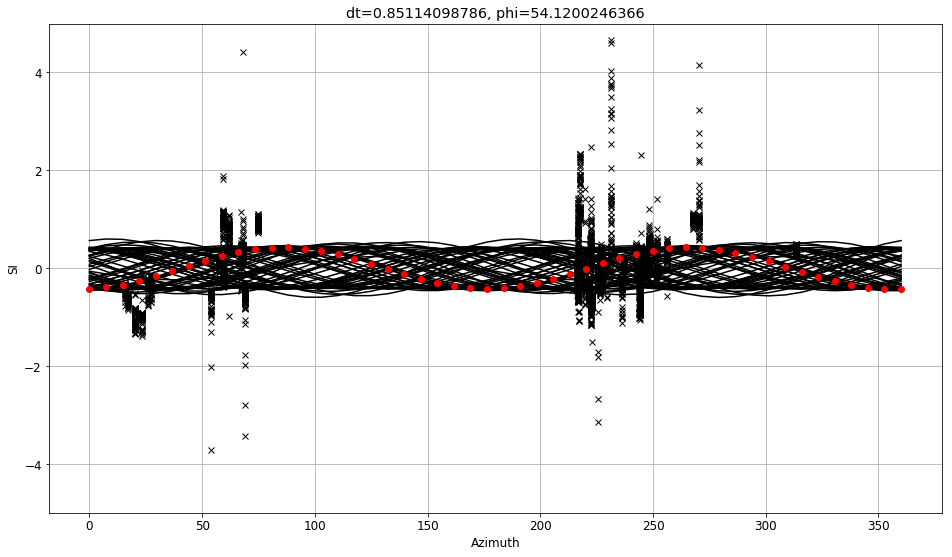

In [353]:
def func2(x, delta_t, phi):
    y = delta_t*0.5*np.sin( 2*(np.radians(x)-phi))
    return y

#val_4[iwin,:] = (dt,phi,std_dt,std_phi) 

#plt.plot(Az_l[0,:],SV_Az_l[0,:],'x')

ix = 0
plt.figure(figsize=(16,9))

print(len(Az_l))
for ix in range(0,len(Az_l[0,:])):
    plt.plot(Az_l[:,ix],SV_Az_l[:,ix],'kx')

    x = np.linspace(0,360)
    y = func2(x,val_4[ix,0],val_4[ix,1])

    plt.plot(x,y,'k')
best_twindow
y = func2(x,val_4[np.argmin(val_4[:,2]),0],val_4[np.argmin(val_4[:,3]),1])

plt.plot(x,y,'ro',label='smallest Errors')
plt.ylim(-5,5)
plt.xlabel('Azimuth')
plt.ylabel('SI')
plt.title('dt={0}, phi={1}'.format(val_4[np.argmin(val_4[:,2]),0],val_4[np.argmin(val_4[:,3]),1]))
plt.grid()
plt.show()


(69, 60)


(-2, 2)

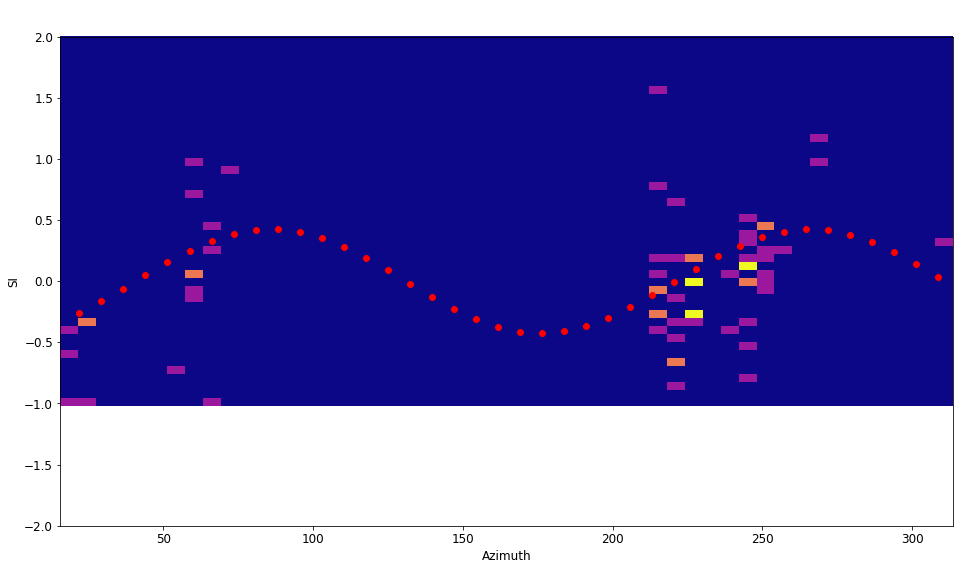

In [354]:
## look at "Heat Map"
#plt.hist2d(x,y)

#plt.hist2d(Az_l[:,ix],SV_Az_l[:,ix],bins=50)
plt.figure(figsize=(16,9))

Az_stack = np.vstack(Az_l)
SV_stack = np.vstack(SV_Az_l)
print(np.shape(Az_stack))

plt.hist2d(Az_l[:,ix],np.mean(SV_stack,axis=1),bins=50,cmap='plasma')
plt.plot(x,y,'ro',label='smallest Errors')

plt.ylabel('SI')
plt.xlabel('Azimuth')
plt.ylim(-2,2)

(60, 4)


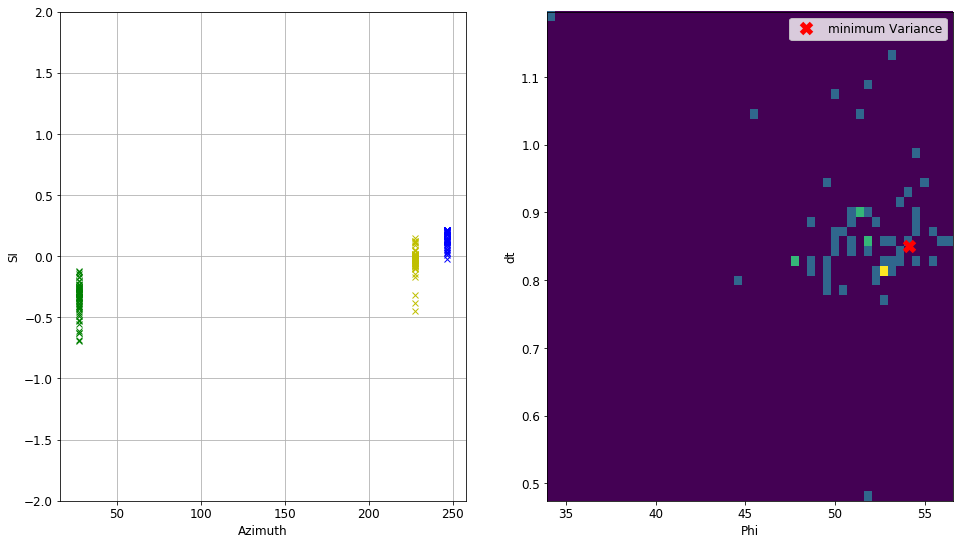

In [355]:
## look at a a cluster of values

## look at the mean
## look at the cluster mean

plt.figure(figsize=(16,9))
plt.subplot(1,2,1)

ie = 10
plt.plot(Az_l[ie,:],SV_Az_l[ie,:],'yx')

x = np.linspace(0,360)
y = func2(x,val_4[ie,0],val_4[ie,1])
#plt.plot(x,y,'y')

ie = 25
plt.plot(Az_l[ie,:],SV_Az_l[ie,:],'bx')
x = np.linspace(0,360)
y = func2(x,val_4[ie,0],val_4[ie,1])
#plt.plot(x,y,'b')


ie = 50
plt.plot(Az_l[ie,:],SV_Az_l[ie,:],'gx')
x = np.linspace(0,360)
y = func2(x,val_4[ie,0],val_4[ie,1])
#plt.plot(x,y,'g')

plt.grid()
plt.ylabel('SI')
plt.xlabel('Azimuth')
plt.ylim(-2,2)
#plt.xlim(180,300)
## 
## split into clusters
#print(,val_4[:,1])
plt.subplot(1,2,2)
print(np.shape(val_4))
plt.hist2d(val_4[:,1],val_4[:,0],bins=50)
plt.plot(val_4[np.argmin(val_4[:,3]),1],val_4[np.argmin(val_4[:,2]),0],'rx',markersize=10,mew=5,label='minimum Variance')
plt.xlabel('Phi')
plt.ylabel('dt')
plt.legend()


(60, 4)


Text(0.5,0.98,'PLONS')

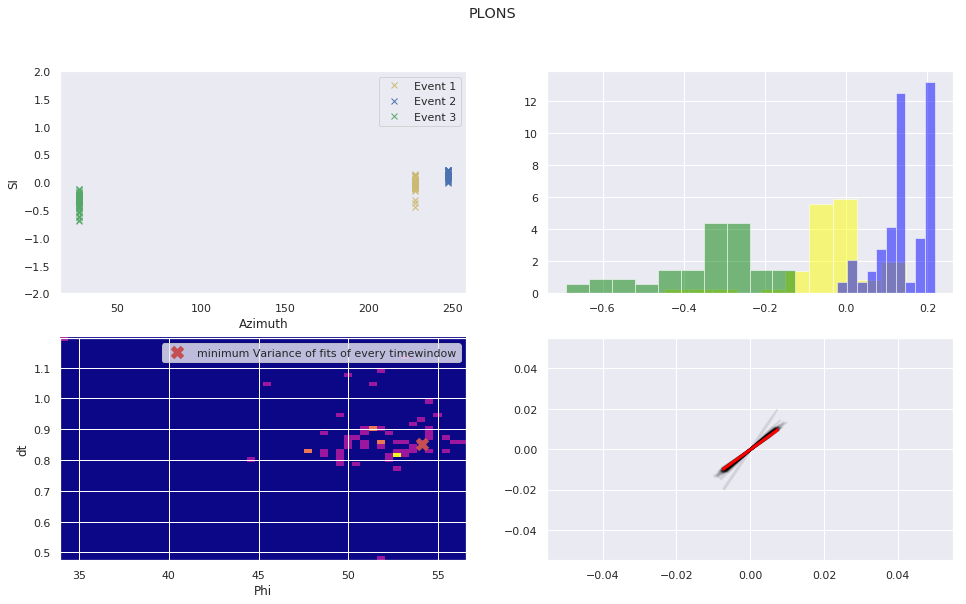

In [475]:
## look at a a cluster of values

## look at the mean
## look at the cluster mean

plt.figure(figsize=(16,9))
plt.subplot(2,2,1)

ie = 10
plt.plot(Az_l[ie,:],SV_Az_l[ie,:],'yx',label='Event 1')

ie = 25
plt.plot(Az_l[ie,:],SV_Az_l[ie,:],'bx',label='Event 2')


ie = 50
plt.plot(Az_l[ie,:],SV_Az_l[ie,:],'gx',label='Event 3')

plt.legend()
plt.grid()
plt.ylabel('SI')
plt.xlabel('Azimuth')
plt.ylim(-2,2)
#plt.xlim(180,300)

plt.subplot(2,2,2)
ie = 10
plt.hist(SV_Az_l[ie,:],color='yellow',alpha=0.5,normed=True)
ie = 25
plt.hist(SV_Az_l[ie,:],color='blue',alpha=0.5,normed=True)
ie = 50
plt.hist(SV_Az_l[ie,:],color='green',alpha=0.5,normed=True)
# get max of distribution
## or mean
## and then fit it 
## compare the arrows

## 
## split into clusters
#print(,val_4[:,1])
plt.subplot(2,2,3)
print(np.shape(val_4))
plt.hist2d(val_4[:,1],val_4[:,0],bins=50,cmap='plasma')
#plt.scatter(p.x,p.y,'w')
plt.plot(val_4[np.argmin(val_4[:,3]),1],val_4[np.argmin(val_4[:,2]),0],'rx',markersize=10,mew=5,label='minimum Variance of fits of every timewindow')
#plt.xlim(0,90)
#plt.ylim(0.5,2)
plt.xlabel('Phi')
plt.ylabel('dt')
plt.legend()

plt.subplot(2,2,4)
scale=5
for i in range(0,len(val_4[:,1])):
    u,v = calc_u_v(val_4[i,0],val_4[i,1])
    a = plt.quiver(0, 0, u, v,pivot='mid',color='black', alpha=0.1, headlength=0, headwidth = 0.5,scale=scale)

u,v = calc_u_v(val_4[np.argmin(val_4[:,2]),0],val_4[np.argmin(val_4[:,3]),1])
plt.quiver(0, 0, u, v,pivot='mid',color='red', alpha=1, headlength=0, headwidth = 1,scale=scale,zorder=10)

plt.suptitle(station)


In [485]:
print(list(val_4[:,0]), sep=',')
#print(str())
#print(val_4[:,1])
# fig, ax = plt.subplots(figsize=(16, 9))
# #ax = plt.Axes(fig, [0., 0., 1., 1.])
# ax.set_axis_off()

# h = 0.22
# b = 0.22
# a1 = 0.10
# a2 = a1+b+0.05
# a3 = a2+b+0.05

# b1 = 0.32
# b2 = b1+b+0.1

# ax1 = fig.add_axes([a1,b2,b,h])
# ax2 = fig.add_axes([a2,b2,b,h])
# ax3 = fig.add_axes([a3,b2,b,h])

# ax4 = fig.add_axes([a1,b1,b,h])
# ax5 = fig.add_axes([a2,b1,b,h])
# ax6 = fig.add_axes([a3,b1,b,h])
# ax7 = fig.add_axes([0.3,0.05,0.3,0.15])
# ax7.set_axis_off()

#p = (sns.jointplot(val_4[:,1],val_4[:,0], kind="kde", space=0, color="g").plot_joint(sns.kdeplot, zorder=0, n_levels=6))

#plt.scatter(p.x,p.y,color='black')

## get the maximum of this cluster
plt.figure(figsize=(16,9))
plt.subplot(3,1,1)
nbins=20
aa,bb,cc = plt.hist(p.x,bins=nbins)
print(bb[np.argmax(aa)])
plt.subplot(3,1,2)
dd,ee,ff = plt.hist(p.y,bins=nbins)

print(ee[np.argmax(dd)])

#n,b,p = plt.hist(p.x)
plt.subplot(3,1,3)
#plt.hist2d(val_4[:,1],val_4[:,0],bins=nbins,cmap='plasma')
plt.scatter(p.x,p.y,color='orange')
plt.scatter(bb[np.argmax(aa)],ee[np.argmax(dd)],color='red',zorder=10,label='maximum Aggregation phi={0},dt={1}'.format(bb[np.argmax(aa)],ee[np.argmax(dd)]))
plt.scatter(val_4[np.argmin(val_4[:,2]),1],val_4[np.argmin(val_4[:,3]),0]
            ,color='green',zorder=10,label='minimum Var phi={0},dt={1}'.format(val_4[np.argmin(val_4[:,2]),1],val_4[np.argmin(val_4[:,3]),0]))

plt.legend()
print()



# q = sns.distplot(val_4[:,1], hist=False, kde=True, color='palevioletred', vertical=False, norm_hist=True, kde_kws={"alpha": 0})
# x,y = q.get_lines()[0].get_data()
# #x = p.
# print(np.max(y))
# r = sns.distplot(val_4[:,0], hist=False, kde=True, color='palevioletred', vertical=False, norm_hist=True, kde_kws={"alpha": 0})
# a,b = r.get_lines()[0].get_data()
# print(np.max(b))


SyntaxError: invalid syntax (<ipython-input-485-85dc2403e5e4>, line 1)

In [489]:
#l = [1,2,3,7] 
#print ", ".join([str(x) for x in val_4[:,1]])

33.941962979, 51.7040138507, 54.5014062128, 44.7791495107, 45.4768729094, 51.4634066604, 53.1647266698, 52.0242608654, 49.8410838062, 52.4404296488, 49.7568045335, 51.0437531458, 55.0366559275, 48.4305493425, 51.6633971256, 48.5705835575, 52.0303603369, 49.9504396542, 49.452573097, 47.733086729, 48.4680739933, 47.5676510841, 49.6969007239, 49.9506607586, 49.7524990932, 52.7017157847, 49.4347401694, 52.8211852884, 50.541103064, 52.8787516334, 49.9229344064, 52.1516101295, 50.7927303391, 53.3072043266, 50.6032946991, 52.8262708593, 53.8503517154, 51.9943401614, 53.9407780828, 51.666821983, 53.7023249209, 51.0239048842, 52.502597254, 50.9886969845, 52.5049492588, 51.2795753409, 53.1496752244, 51.2199770187, 52.507491852, 54.5219397, 53.3698649575, 55.4663640536, 54.4011857666, 56.5781060527, 54.4077194186, 55.7548587734, 54.1200246366, 55.5813974235, 53.6836491307, 54.7599768069


0.0
1.0
0
Independent (fail to reject H0)
(0.68641735289006811, 1.0)
(0.68641735289006811, 1.0)


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  3.,
         0.,  0.,  0.,  2.,  3.,  4.,  0.,  0.,  2.,  1.,  3.,  2.,  1.,
         3.,  3.,  1.,  2.,  3.,  3.,  2.,  2.,  0.,  3.,  1.,  1.,  4.,
         1.,  0.,  1.,  0.,  2.,  1.,  0.,  0.,  1.]),
 array([ 33.94196298,  34.16832441,  34.39468584,  34.62104727,
         34.8474087 ,  35.07377013,  35.30013156,  35.52649299,
         35.75285442,  35.97921586,  36.20557729,  36.43193872,
         36.65830015,  36.88466158,  37.11102301,  37.33738444,
         37.56374587,  37.7901073 ,  38.01646873,  38.24283016,
         38.46919159,  38.69555302,  38.92191446,  39.14827589,
         39.37463732,  39.60099875,  39.82736018, 

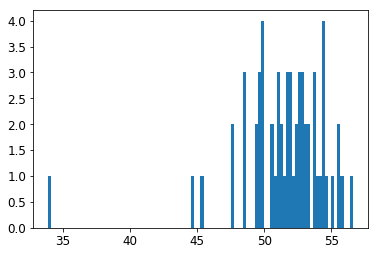

In [361]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# contingency table

## some more chisquare metrics
## sum of chi2 = (expected-observed)^2/expected
## EXAMPLE

## load in the Barruol result
## generate a normal distribution --> expected
## take the observed and calc chisuq

path = '/media/hein/home2/SKS_automatic_splitwave/code_latest/'
station_barr,lat,lon,fast_barr,dfast_barr,lag_barr,dlag_barr,nSKS = load_in_Barruol_table(path)
station_barr = station_barr.tolist()




mu, sigma = lag_barr[station_barr.index(station)], dlag_barr[station_barr.index(station)] # mean and standard deviation
s = np.random.normal(mu, sigma, len(val_4[:,1]))

## test one parameter against the other one, if normal distributed

table = [val_4[:,1]]
#print(table)
stat, p, dof, expected = chi2_contingency(table)
#    print('dof=%d' % dof)
#    print(expected)
# interpret test-statistic
print(stat)
print(p)
print(dof)
# interpret p-value
alpha = 1.0 - prob
#    print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    a0=0
    print('Independent (fail to reject H0)')
    
    
    
    


#############
#print(val_4[:,1])
val_4[:,1]=(val_4[:,1]+180)%180    
#print(val_4[:,1])
chisquare,p = stats.chisquare(val_4[:,0])
print(chisquare,p)
#chisquare,p = stats.chisquare()
print(chisquare,p)
plt.hist(val_4[:,1],bins=100)

# print('#### CHISQUARE Test (max (p))')
# print(val_4[np.argmax(p),0],val_4[np.argmax(p),1],val_4[np.argmax(p),2],val_4[np.argmax(p),3])
# print('#### MINIMUM VARIANCE')
# print(val_4[np.argmin(val_4[:,2]),0],val_4[np.argmin(val_4[:,3]),1],val_4[np.argmin(val_4[:,2]),2],val_4[np.argmin(val_4[:,3]),3])
# print(station)


In [358]:



mu, sigma = lag_barr[station_barr.index(station)], dlag_barr[station_barr.index(station)] # mean and standard deviation
s = np.random.normal(mu, sigma, len(val_4[:,1]))

## test one parameter against the other one, if normal distributed



#print(table)
stat, p, dof, expected = chi2_contingency(table)
#    print('dof=%d' % dof)
#    print(expected)
# interpret test-statistic
print(stat)
print(p)
print(dof)
# interpret p-value
alpha = 1.0 - prob
#    print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    a0=0
    print('Independent (fail to reject H0)')
    
    


0.0
1.0
0
Independent (fail to reject H0)


60
59


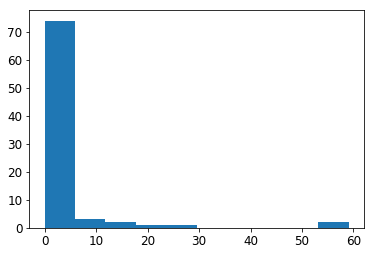

In [ ]:

def calc_u_v(r,phi):
    
    if (phi>=0 and phi<=90):
        phi=90-phi
        u = r*np.cos(np.deg2rad(phi))
        v = r*np.sin(np.deg2rad(phi))
    elif (phi>90 and phi<=180):
        phi=180-phi
        u = r*np.sin(np.deg2rad(phi))
        v = -r*np.cos(np.deg2rad(phi))    
    elif (phi>180 and phi<=270):
        phi=270-phi
        u = -r*np.cos(np.deg2rad(phi))
        v = -r*np.sin(np.deg2rad(phi))    
    elif (phi>270 and phi<=360):
        phi=360-phi
        u = -r*np.sin(np.deg2rad(phi))
        v = r*np.cos(np.deg2rad(phi))    
    elif (phi>=-90 and phi<0):
        phi=abs(phi)
        u = -r*np.sin(np.deg2rad(phi))
        v = r*np.cos(np.deg2rad(phi))            
    elif (phi>=-180 and phi<-90):
        phi=180-abs(phi)
        u = -r*np.sin(np.deg2rad(phi))
        v = -r*np.cos(np.deg2rad(phi))                    
        
    return u,v

In [ ]:

#     vals = [str(st_cut[0].stats.station),
#            val_4[np.argmin(val_4[:,3]),1],
#            val_4[np.argmin(val_4[:,3]),3],
#            val_4[np.argmin(val_4[:,2]),0],
#            val_4[np.argmin(val_4[:,2]),2],
#            best_twindow, 
#            chisquare_phi4,
#            p_phi4,
#            chisquare_dt4,
#            p_phi4,
#            len(ev_time_l)]
#     method = 'Chevrot'    
    
#     write_SKS_Results_CHEV(txt_path, method, vals, header2)    
#     print('Processed Chevrot for Station',st_cut[0].stats.station)

    ########################################################################################################################################################################
    ########################################################################################################################################################################    
    ### finish the data



#     method = 'TransM'
#     write_head(txt_path, method, station,header)     
#     method = 'CrossC'
#     write_head(txt_path, method, station,header)     
#     method = 'EigM'
#     write_head(txt_path, method, station,header)     
#     ########################################################################################################################################################################

#     ##### INCREASE EVENTS HERE
#     for nevent in range(0,len(ev_time_l)):
# #    for nevent in tqdm(range(0,3)):    
#     ########################################################################################################################################################################

#         st_cut = n_event_st_cut(nevent)


#         SNR = calc_SNR(st_cut)

#         back_az = back_azimut_l[nevent]


#         ## minimum distance from trace of 2 minutes
#         #t1 = 58
#         #t2 = 65
#         t1 = 56
#         t2 = 64
#         ## make the windowlength from small to big
#         windowlength = np.linspace(0,45,60)
#         legendbox =(0.9,0.6)
#         prop_size = 8

#         xxl = (0,95)

#         values_1 = np.ones((len(windowlength),4))*-1000 ## Matrix for TransM
#         values_2 = np.ones((len(windowlength),4))*-1000 ## Matrix for CrossC
#         values_3 = np.ones((len(windowlength),4))*-1000 ## Matrix for EigM

#         ### save the best time windows
#         best_win_phi = np.zeros((len(ev_time_l),6))
#         best_win_dt = np.zeros((len(ev_time_l),6))


#         iwindow = 0
#         ##############################################################################################################################
#         ##############################################################################################################################   
#         for iwin in windowlength:    
#             fast, dfast,lag,dlag = Splitwave_TransM(st_cut,t1-iwin,t2+iwin,back_az,plot=False)
#             values_1[iwindow,:] = (fast,dfast,lag,dlag)    
#             fast, dfast,lag,dlag = Splitwave_CrossC(st_cut,t1-iwin,t2+iwin,plot=False)              
#             values_2[iwindow,:] = (fast,dfast,lag,dlag)
#             fast, dfast,lag,dlag = Splitwave_EigM(st_cut,t1-iwin,t2+iwin,plot=False)            
#             values_3[iwindow,:] = (fast,dfast,lag,dlag)        
#             iwindow += 1
#                 ##############################################################################################################################
#                 ##############################################################################################################################

# #             except:
# #                 print(t1-iwin,t2+iwin)
# #                 print('most likely Error of Degree of Freedom , time window too short')            
# #                 pass
# #                 ##############################################################################################################################


#     ######################
#         #### EXCLUDE THE Artifical Values 
#         windowlength_1 = windowlength[np.where(np.isnan(values_1)==False)[0][::4]]        
#         values_1 = values_1[np.where(values_1!=-1000)]
#         values_1 = values_1.reshape(len(values_1)/4,4)
            
#         values_1 = values_1[np.where(np.isnan(values_1)==False)]
#         values_1 = values_1.reshape(len(values_1)/4,4)        
        

#         windowlength_2 = windowlength[np.where(np.isnan(values_2)==False)[0][::4]]                
#         values_2 = values_2[np.where(values_2!=-1000)]
#         values_2 = values_2.reshape(len(values_2)/4,4)
        
#         values_2 = values_2[np.where(np.isnan(values_2)==False)]
#         values_2 = values_2.reshape(len(values_2)/4,4)        

#         windowlength_3 = windowlength[np.where(np.isnan(values_3)==False)[0][::4]]        
#         values_3 = values_3[np.where(values_3!=-1000)]
#         values_3 = values_3.reshape(len(values_3)/4,4)
        
#         values_3 = values_3[np.where(np.isnan(values_3)==False)]
#         values_3 = values_3.reshape(len(values_3)/4,4)        